In [ ]:
from notebooks import *
sg.init(app=None)

INFO     [19:18:28.379] [50511]  52 logging_/init_logging: {logging_yaml: None}

INFO     [19:18:28.684] [50511]  29 api.server_globals/init

INFO     [19:18:29.376] [50511]  31 api.server_globals/init: done

In [ ]:

def opt(*args, **kwargs):
    verbose_keys = ['cache', 'audio']
    verbose(*args, **{k: v for k, v in kwargs.items() if k in verbose_keys})
    par(**{k: v for k, v in kwargs.items() if k not in verbose_keys})

def par(**kwargs):
    """
    Usage:
        par(use=None)                         # No par, no progress bars (easier to see audio read/write and cache hit/miss)
        par(use='sync')                       # No par, cooperative progress bars (no lines printing over each other)
        par(use='dask', scheduler='threads')  # Par, uncooperative progress bars (lines print over each other)
    """
    progress_kwargs(override=kwargs)

def verbose(
    both=None,       # Shorthand, e.g. verbose('warn') = verbose(cache='warn', audio='warn')
    *,
    cache='debug',   # Show cache hit/miss lines # WARNING Frequent hangs during bigger xc_similar_html calls...
    # cache='info',  # Show cache hit/miss chars # WARNING (same)
    # cache='warn',  # Quiet
    audio='debug',   # Show read/write
    # audio='info',  # Show write
    # audio='warn',  # Quiet
):
    if both:
        cache = both
        audio = both
    memory.log.level = cache
    log_levels({'load': audio.upper()})

def n_recs_by_sp_quality(df):
    return (df
        # Count recs by (species, quality)
        .pipe(df_remove_unused_categories)
        .assign(n=1).groupby(['species', 'quality']).n.sum().reset_index()
        # Strip and restore .species cat around .pivot_table to workaround category error when adding .total
        .pipe(df_cat_to_str)
        # Pivot
        .pivot_table(index='species', columns='quality', values='n', fill_value=0, aggfunc='sum',
            margins=True, margins_name='total',  # FIXME 'total' ends up as NaN because we cat .species
        )
        # Restore .species cat
        .reset_index().astype({'species': metadata.species.df.shorthand.dtype}).sort_values('species').set_index('species')
        # Drop columns.name from .pivot_table ('quality')
        .T.pipe(df_set_index_name, None).T
        # Add .total
        # .pipe(df_assign_first, total=lambda df: df.sum(axis=1))
        .pipe(df_reorder_cols, first=['total'])
        # Sort
        .sort_values('total', ascending=False)
    )

In [ ]:
# How many recs per (species, quality)?
(sg.xc_meta
    # [lambda df: df.species.isin(['SNGO', 'HOFI', 'GWTE', 'YHBL'])]  # Faster dev
    .pipe(n_recs_by_sp_quality)
    .iloc[:20]
)

,total,A,B,C,D,E,no score
species,,,,,,,
NaN,35233,12109,14928,5434,1168,301,1293
RECR,659,94,281,209,63,12,0
SOSP,648,251,246,116,19,8,8
BEWR,522,168,252,69,3,0,30
SPTO,521,234,198,70,8,2,9
FOSP,501,267,153,59,14,1,7
RWBL,497,142,247,79,19,5,5
HOWR,476,163,219,55,13,2,24
AMRO,443,140,205,75,12,8,3


INFO     [19:40:02.870] [50511] 831 datasets/xc_meta_to_raw_recs: Loading xc.metadata -> xc_raw_recs (.audio, more metadata)... [slower]

INFO     [19:40:02.895] [50511] 816 datasets/xc_meta_to_paths: Converting xc_meta -> xc_paths...

to_paths_sliced: [

] |   0% (1) |  0.0s

to_paths_sliced: [

#################################################################################

] | 100% (1) |  0.1s

audio_metadata: [

] |   0% (1) |  0.0s

audio_metadata: [

##################################################################################

] | 100% (1) |  0.1s

feat: [

] |   0% (1) |  0.0s

feat: [

############################################################################################

] | 100% (1) |  0.1s

INFO     [19:40:03.524] [50511] 831 datasets/xc_meta_to_raw_recs: Loading xc.metadata -> xc_raw_recs (.audio, more metadata)... [slower]

INFO     [19:40:03.545] [50511] 816 datasets/xc_meta_to_paths: Converting xc_meta -> xc_paths...

to_paths_sliced: [

] |   0% (717) |  0.0s

to_paths_sliced: [

###############################################################################

] | 100% (717) |  0.1s

audio_metadata: [

] |   0% (717) |  0.0s

audio_metadata: [

] |   0% (717) |  0.1s

audio_metadata: [

################                                                                

] |  20% (717) |  0.2s

audio_metadata: [

################################                                                

] |  40% (717) |  0.4s

audio_metadata: [

################################################                                

] |  60% (717) |  0.5s

audio_metadata: [

############################################################                    

] |  75% (717) |  0.6s

audio_metadata: [

################################################################                

] |  80% (717) |  0.7s

audio_metadata: [

################################################################################

] | 100% (717) |  0.8s

feat: [

] |   0% (717) |  0.0s

feat: [

####                                                                                      

] |   5% (717) |  0.1s

feat: [

#########                                                                                 

] |  10% (717) |  0.2s

feat: [

#############                                                                             

] |  15% (717) |  0.3s

feat: [

####################                                                                      

] |  22% (717) |  0.4s

feat: [

########################                                                                  

] |  27% (717) |  0.5s

feat: [

#############################                                                             

] |  32% (717) |  0.6s

feat: [

##################################                                                        

] |  38% (717) |  0.7s

feat: [

########################################                                                  

] |  45% (717) |  0.9s

feat: [

#############################################                                             

] |  50% (717) |  1.0s

feat: [

###################################################                                       

] |  57% (717) |  1.1s

feat: [

########################################################                                  

] |  62% (717) |  1.2s

feat: [

############################################################                              

] |  67% (717) |  1.3s

feat: [

#################################################################                         

] |  72% (717) |  1.4s

feat: [

########################################################################                  

] |  80% (717) |  1.5s

feat: [

############################################################################              

] |  85% (717) |  1.6s

feat: [

###################################################################################       

] |  92% (717) |  1.7s

feat: [

#######################################################################################   

] |  97% (717) |  1.8s

feat: [

##########################################################################################

] | 100% (717) |  1.9s

f: [

] |   0% (718) |  0.0s

f: [

#############################################################################################

] | 100% (718) |  0.1s

d_f2: [

] |   0% (718) |  0.0s

d_f2: [

##########################################################################################

] | 100% (718) |  0.1s

d_fc: [

] |   0% (718) |  0.0s

d_fc: [

##########################################################################################

] | 100% (718) |  0.1s

p: [

] |   0% (718) |  0.0s

p: [

] |   0% (718) |  0.1s

p: [

] |   0% (718) |  0.2s

p: [

] |   0% (718) |  0.3s

p: [

] |   0% (718) |  0.4s

p: [

] |   0% (718) |  0.5s

p: [

] |   0% (718) |  0.6s

p: [

] |   0% (718) |  0.7s

p: [

] |   0% (718) |  0.8s

p: [

] |   0% (718) |  0.9s

p: [

#############################################################################################

] | 100% (718) |  1.0s

d_p2: [

] |   0% (718) |  0.0s

d_p2: [

##########################################################################################

] | 100% (718) |  0.1s

d_pc: [

] |   0% (718) |  0.0s

d_pc: [

##########################################################################################

] | 100% (718) |  0.1s

audio: [

] |   0% (10) |  0.0s

audio: [

] |   0% (10) |  0.1s

audio: [

##########################################################################################

] | 100% (10) |  0.2s

spectro: [

] |   0% (10) |  0.0s

spectro: [

########################################################################################

] | 100% (10) |  0.1s

plot_slice: [

] |   0% (10) |  0.0s

plot_slice: [

] |   0% (10) |  0.1s

plot_slice: [

#################                                                                    

] |  20% (10) |  0.3s

plot_slice: [

#####################################################################################

] | 100% (10) |  0.4s

,xc_id,d_slp,d_f2,d_p2,d_fc,d_pc,species,quality,slice,duration_s,month_day,background_species,place,remarks
0,381417,0.0,0.0,2.63e-09,0.0,3.33e-16,YHBL,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",3.07,06-03,[],"Carpenter Ranch, Routt County, Colorado, United States",Natural vocalization from cattails around a small pond.
1,381417,0.0,0.0,2.63e-09,0.0,3.33e-16,YHBL,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",3.07,06-03,[],"Carpenter Ranch, Routt County, Colorado, United States",Natural vocalization from cattails around a small pond.
2,293877,3.54,38.4,0.109,0.0827,0.43,GWTE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,11-21,"['NOPI', 'MALL']","Blaine, Whatcom County, Washington, United States",Teals were in a mixed flock of including Northern Pintails and Mallards. Recording starts with Green-Winged Teal at 0:11 Northern Pintails are the dominant calls heard. The background noise is made...
3,221967,3.61,24.2,0.0886,0.0867,0.363,STJA,B,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-21,[],"Cerro San Felipe (La Cumbre), Oaxaca, Mexico",ID certainty 80%. (Archiv. tape 125 side B track 6 seq. A)
4,218816,3.57,72.3,0.217,0.0883,0.729,GRHE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,06-05,[],"Peacocks Pocket Road, Merritt Island National Wildlife Refuge, Florida, United States",
5,143632,3.54,39.2,0.118,0.0886,0.39,GWTE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-23,[],"Tijuana Slough NWR, Imperial Beach, San Diego County, California, United States",Male whistle calls and female calls
6,72510,3.54,24.9,0.0869,0.0895,0.351,GWTE,B,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,02-27,[],"Taylor's Refuge, Cinnaminson, NJ, United States","birds not seen, male burps and female chattering"
7,97309,3.54,39.1,0.143,0.0905,0.545,GWTE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-24,[],"Vernon Marsh, Waukesha County, Wisconsin, United States",
8,221969,3.61,26.5,0.104,0.0906,0.426,STJA,B,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-21,[],"Cerro San Felipe (La Cumbre), Oaxaca, Mexico",ID certainty 80%. (Archiv. tape 125 side B track 8 seq. A)
9,326526,3.57,38.4,0.133,0.0912,0.517,GRHE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",6.97,07-08,[],"Playalinda Beach, Canaveral NS, Brevard County, Florida, United States",flying out of mangroves

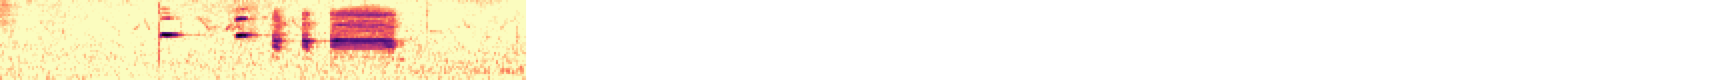
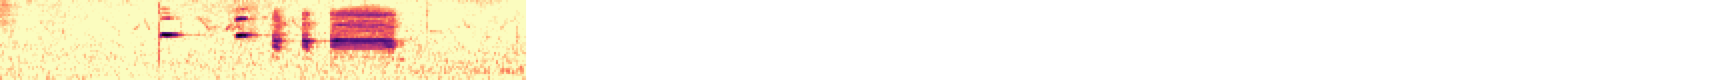
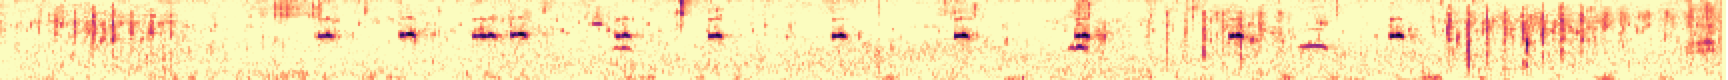
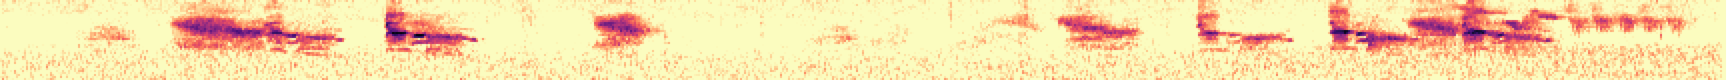
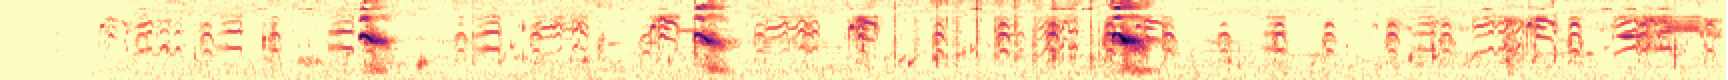
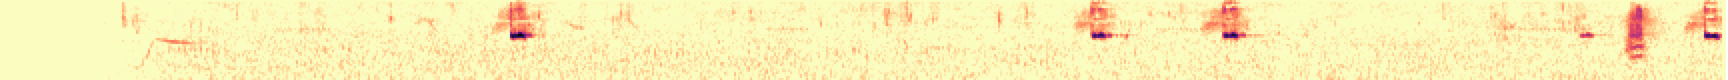
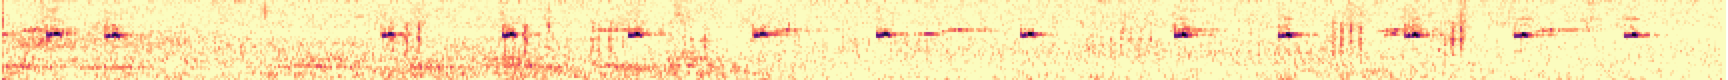
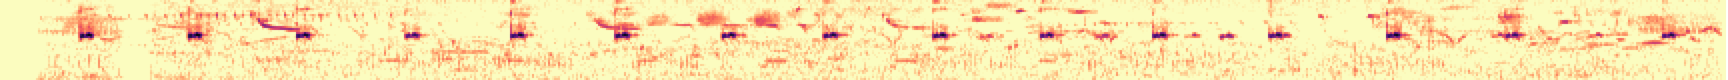
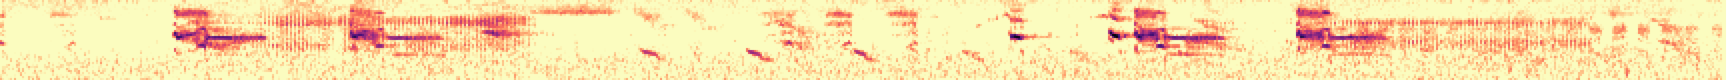
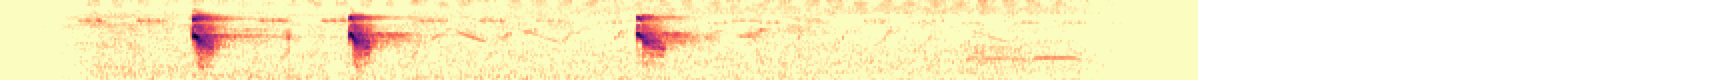

[mem_delta] {
  'rss': '13792 KB',
  'vms': '13760 KB',
  'pfaults': '89 KB',
  'pageins': '0 KB',
  'uss': '89548 KB'
}

peak memory: 923.98 MiB, increment: 121.11 MiB

In [ ]:
%%memit -c
opt('warn', use='dask', scheduler='threads')  # Quiet + par + progress bars
# opt('warn', use='sync')
# opt('debug', use='sync')  # Verbose + sync + no progress bars
with ExitStack() as stack:
    stack.enter_context(print_mem_delta(collect_before=True, collect_after=False))
    stack.enter_context(cache_control(
        tags_fail_on_miss=['rec'],  # Require warmed cache for 'rec' funcs
        tags_refresh=['recs'],  # Measure un-warmed cache for 'recs' funcs
    ))
    display(
        xc_similar_html(
            sort='d_fc',
            sp_cols='species',

            # Perf bottlenecks
            #   - meta: O(n) cache hits
            #   - feat: O(n) cache hits
            #   - p:    O(n) sg.search.predict_proba [@cache would achieve perf ~between meta and feat, which is only ~2x speedup]
            # xc_id=381417, n_total=10,   n_sp=1,    sample_r=None,  # t[4.0s] %m[ 123mb] n_recs[   32,0] p[meta 0.1 feat 0.1 p 0.1]
            xc_id=381417, n_total=10,   n_sp=10,   sample_r=None,  # t[7.1s] %m[ 107mb] n_recs[  717,0] p[meta 0.8 feat 1.5 p 0.5]
            # xc_id=381417, n_total=10,   n_sp=40,   sample_r=None,  # t[ 25s] %m[ 300mb] n_recs[ 3879,1] p[meta 3.7 feat 7.6 p 5.1]
            # xc_id=381417, n_total=10,   n_sp=80,   sample_r=None,  # t[ 51s] %m[ 310mb] n_recs[ 8203,1] p[meta 7.6 feat  18 p  14]
            # xc_id=381417, n_total=10,   n_sp=160,  sample_r=None,  # t[111s] %m[ 637mb] n_recs[15284,1] p[meta  14 feat  36 p  42]
            # xc_id=381417, n_total=10,   n_sp=None, sample_r=None,  # t[192s] %m[1186mb] n_recs[27033,2] p[meta  25 feat  62 p  72]

            # NOTE n_sp=None -> 27035/35233 recs because quality='ab'
            # TODO TODO Then continue [from notes]

            # view=False,  # For .pipe(n_recs_by_sp_quality): disable html view else junk .species values
        )
        # .pipe(n_recs_by_sp_quality)
    )

INFO     [19:42:52.267] [50511] 831 datasets/xc_meta_to_raw_recs: Loading xc.metadata -> xc_raw_recs (.audio, more metadata)... [slower]

INFO     [19:42:52.273] [50511] 816 datasets/xc_meta_to_paths: Converting xc_meta -> xc_paths...

to_paths_sliced: [

] |   0% (1) |  0.0s

to_paths_sliced: [

#################################################################################

] | 100% (1) |  0.1s

INFO     [19:42:52.592] [50511] 831 datasets/xc_meta_to_raw_recs: Loading xc.metadata -> xc_raw_recs (.audio, more metadata)... [slower]

INFO     [19:42:52.600] [50511] 816 datasets/xc_meta_to_paths: Converting xc_meta -> xc_paths...

to_paths_sliced: [

] |   0% (717) |  0.0s

to_paths_sliced: [

###############################################################################

] | 100% (717) |  0.1s

f: [

] |   0% (718) |  0.0s

f: [

#############################################################################################

] | 100% (718) |  0.1s

d_f2: [

] |   0% (718) |  0.0s

d_f2: [

##########################################################################################

] | 100% (718) |  0.1s

d_fc: [

] |   0% (718) |  0.0s

d_fc: [

##########################################################################################

] | 100% (718) |  0.1s

p: [

] |   0% (718) |  0.0s

p: [

] |   0% (718) |  0.1s

p: [

] |   0% (718) |  0.2s

p: [

] |   0% (718) |  0.3s

p: [

] |   0% (718) |  0.4s

p: [

] |   0% (718) |  0.5s

p: [

] |   0% (718) |  0.6s

p: [

] |   0% (718) |  0.7s

p: [

] |   0% (718) |  0.8s

p: [

#############################################################################################

] | 100% (718) |  1.0s

d_p2: [

] |   0% (718) |  0.0s

d_p2: [

##########################################################################################

] | 100% (718) |  0.1s

d_pc: [

] |   0% (718) |  0.0s

d_pc: [

##########################################################################################

] | 100% (718) |  0.1s

audio: [

] |   0% (10) |  0.0s

audio: [

##################                                                                        

] |  20% (10) |  0.1s

audio: [

##########################################################################################

] | 100% (10) |  0.2s

spectro: [

] |   0% (10) |  0.0s

spectro: [

########################################################################################

] | 100% (10) |  0.1s

plot_slice: [

] |   0% (10) |  0.0s

plot_slice: [

#################                                                                    

] |  20% (10) |  0.1s

plot_slice: [

#####################################################################################

] | 100% (10) |  0.2s

,xc_id,d_slp,d_f2,d_p2,d_fc,d_pc,species,quality,slice,duration_s,month_day,background_species,place,remarks
0,381417,0.0,0.0,2.63e-09,0.0,3.33e-16,YHBL,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",3.07,06-03,[],"Carpenter Ranch, Routt County, Colorado, United States",Natural vocalization from cattails around a small pond.
1,381417,0.0,0.0,2.63e-09,0.0,3.33e-16,YHBL,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",3.07,06-03,[],"Carpenter Ranch, Routt County, Colorado, United States",Natural vocalization from cattails around a small pond.
2,293877,3.54,38.4,0.109,0.0827,0.43,GWTE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,11-21,"['NOPI', 'MALL']","Blaine, Whatcom County, Washington, United States",Teals were in a mixed flock of including Northern Pintails and Mallards. Recording starts with Green-Winged Teal at 0:11 Northern Pintails are the dominant calls heard. The background noise is made...
3,221967,3.61,24.2,0.0886,0.0867,0.363,STJA,B,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-21,[],"Cerro San Felipe (La Cumbre), Oaxaca, Mexico",ID certainty 80%. (Archiv. tape 125 side B track 6 seq. A)
4,218816,3.57,72.3,0.217,0.0883,0.729,GRHE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,06-05,[],"Peacocks Pocket Road, Merritt Island National Wildlife Refuge, Florida, United States",
5,143632,3.54,39.2,0.118,0.0886,0.39,GWTE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-23,[],"Tijuana Slough NWR, Imperial Beach, San Diego County, California, United States",Male whistle calls and female calls
6,72510,3.54,24.9,0.0869,0.0895,0.351,GWTE,B,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,02-27,[],"Taylor's Refuge, Cinnaminson, NJ, United States","birds not seen, male burps and female chattering"
7,97309,3.54,39.1,0.143,0.0905,0.545,GWTE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-24,[],"Vernon Marsh, Waukesha County, Wisconsin, United States",
8,221969,3.61,26.5,0.104,0.0906,0.426,STJA,B,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",10.0,03-21,[],"Cerro San Felipe (La Cumbre), Oaxaca, Mexico",ID certainty 80%. (Archiv. tape 125 side B track 8 seq. A)
9,326526,3.57,38.4,0.133,0.0912,0.517,GRHE,A,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",6.97,07-08,[],"Playalinda Beach, Canaveral NS, Brevard County, Florida, United States",flying out of mangroves

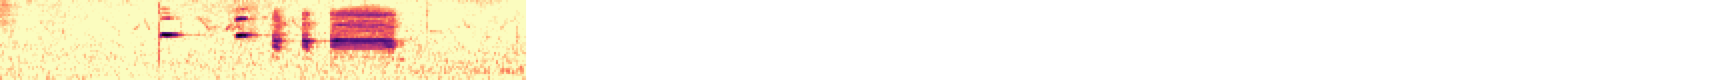
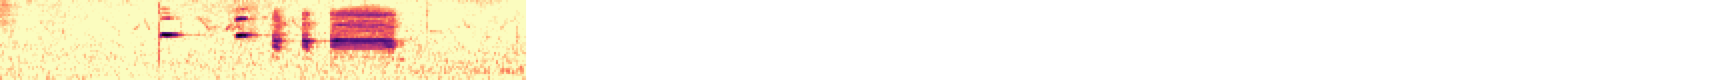
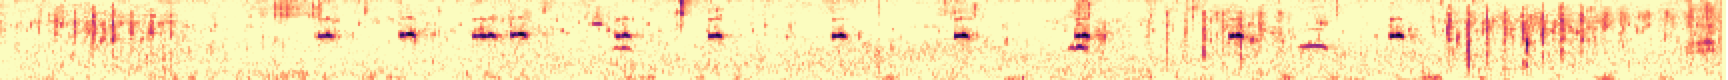
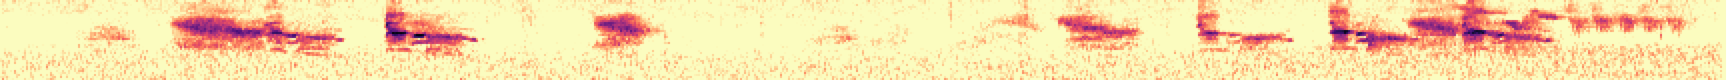
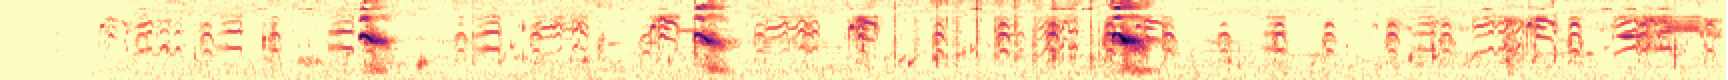
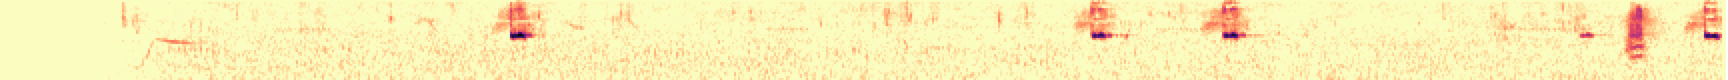
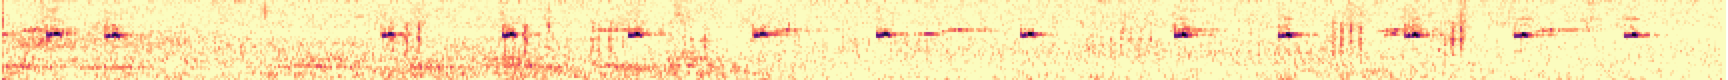
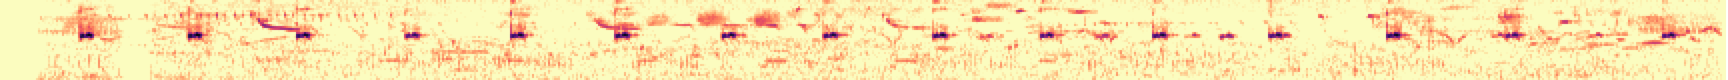
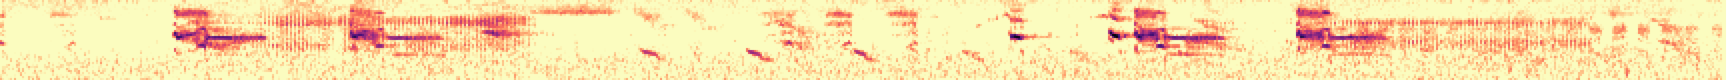
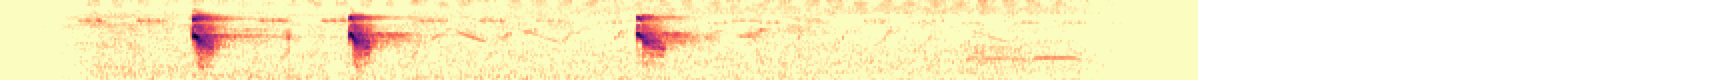

In [ ]:
opt('warn', use='dask', scheduler='threads')  # Quiet + par + progress bars
# opt('warn', use='sync')
# opt('debug', use='sync')  # Verbose + sync + no progress bars
xc_similar_html(
    sort='d_fc',
    sp_cols='species',

    # Redo after deduping species_proba computation
    #   - meta: O(n) cache hits
    #   - feat: O(n) cache hits
    #   - p:    O(n) sg.search.predict_proba [@cache would achieve perf ~between meta and feat, which is only ~2x speedup]
    # xc_id=381417, n_total=10,   n_sp=1,    sample_r=None,  # t[4.0s] %m[ 123mb] n_recs[   32,0] p[meta 0.1 feat 0.1 p 0.1]
    xc_id=381417, n_total=10,   n_sp=10,   sample_r=None,  # t[7.1s] %m[ 107mb] n_recs[  717,0] p[meta 0.8 feat 1.5 p 0.5]
    # xc_id=381417, n_total=10,   n_sp=40,   sample_r=None,  # t[ 25s] %m[ 300mb] n_recs[ 3879,1] p[meta 3.7 feat 7.6 p 5.1]
    # xc_id=381417, n_total=10,   n_sp=80,   sample_r=None,  # t[ 51s] %m[ 310mb] n_recs[ 8203,1] p[meta 7.6 feat  18 p  14]
    # xc_id=381417, n_total=10,   n_sp=160,  sample_r=None,  # t[111s] %m[ 637mb] n_recs[15284,1] p[meta  14 feat  36 p  42]
    # xc_id=381417, n_total=10,   n_sp=None, sample_r=None,  # t[192s] %m[1186mb] n_recs[27033,2] p[meta  25 feat  62 p  72]

    # NOTE n_sp=None -> 27035/35233 recs because quality='ab'
    # TODO TODO Then continue [from notes]

)